<a href="https://colab.research.google.com/github/SamrudhPS/pokidex2/blob/main/pokidex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"samrudhps","key":"7f19488e9a91af40420650e38f233e5e"}'}

In [3]:
!ls

'kaggle (1).json'   sample_data


In [5]:
!mv "kaggle (1).json" kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [7]:
!kaggle datasets download -d bhawks/pokemon-generation-one-22k


Dataset URL: https://www.kaggle.com/datasets/bhawks/pokemon-generation-one-22k
License(s): other
 96% 1.26G/1.31G [00:11<00:00, 79.1MB/s]
100% 1.31G/1.31G [00:12<00:00, 116MB/s] 


In [8]:
!unzip -q /content/pokemon-generation-one-22k.zip -d /content/

FYI: Some of the notes here are just me figuring things out ,don’t mind them.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
!ls /content

kaggle.json  PokemonData  pokemon-generation-one-22k.zip  sample_data


In [11]:
data_path = "/content/PokemonData"   # extracted Pokemon dataset folder


In [12]:
os.path.exists(data_path)


True

Here classes are the unique number of pokemon we will be identifying.

In [13]:
classes = sorted(os.listdir(data_path))
print("Number of Pokémon classes:", len(classes))
print("First 10 classes:", classes[:10])

Number of Pokémon classes: 151
First 10 classes: ['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur']


In [14]:
image_count = {}

for cls in classes:
    cls_path = os.path.join(data_path, cls)
    image_count[cls] = len(os.listdir(cls_path))

for k, v in list(image_count.items())[:10]:
    print(f"{k}: {v}")

print("\nTotal images:", sum(image_count.values()))


Abra: 114
Aerodactyl: 112
Alakazam: 140
Arbok: 141
Arcanine: 115
Articuno: 132
Beedrill: 89
Bellsprout: 115
Blastoise: 111
Bulbasaur: 103

Total images: 20099


The total images is 20099 which is a good dataset,more the number of data better the training of our model.

In [15]:
import random

sample_class = random.choice(classes)
sample_path = os.path.join(data_path, sample_class)
sample_image = random.choice(os.listdir(sample_path))

img = Image.open(os.path.join(sample_path, sample_image))
img_array = np.array(img)

print("Sample class:", sample_class)
print("Image name:", sample_image)
print("Image shape:", img_array.shape)



Sample class: Dragonair
Image name: Dragonair67.jpg
Image shape: (269, 269, 3)


As we can see above that its a standard rgb 3 channel with H-326,W-350. I think we are going to resize it later.

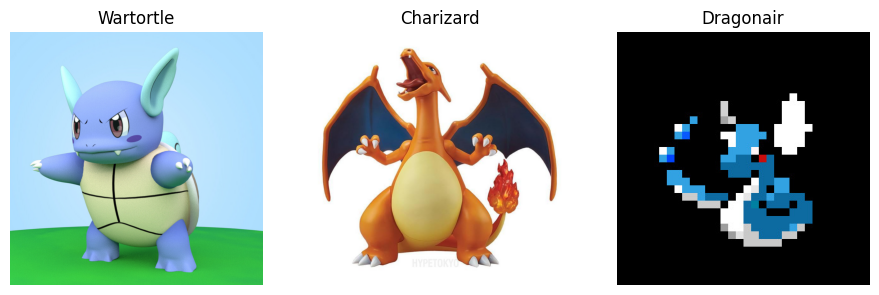

In [35]:
plt.figure(figsize=(15, 8))

for i in range(3):
    cls = random.choice(classes)
    img_name = random.choice(os.listdir(os.path.join(data_path, cls)))
    img_path = os.path.join(data_path, cls, img_name)

    img = Image.open(img_path)

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.show()


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


As we saw earlier the data needed resizing.we will finish with that.

In [39]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [40]:
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
num_classes = len(full_dataset.classes)
print("Number of Pokemon classes:", num_classes)
print("Total images:", len(full_dataset))


Number of Pokemon classes: 151
Total images: 20099


In [41]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


In [43]:
batch_size = 32 #standard batch

#val_dataset = ImageFolder(val_dir, transform=val_transform) #this is the part that replaces randomsplit
#train_dataset = ImageFolder(train_dir, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) #dataLoader is for creating batches.
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [44]:
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [40]:
class PokemonCNN(nn.Module):
    def __init__(self, num_classes):
        super(PokemonCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256 * 8 * 8, 256), #128/2/2/2/2 =8
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Now we can say our base model or model version 1 is created.
overview of model-it has 4 blocks each containing 4layers-conv2d,batchnorm,relu,maxpool.
Then we have classifier which has flattening layer,linear layer(very imp),dropout.

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PokemonCNN(num_classes).to(device)


NameError: name 'PokemonCNN' is not defined

In [46]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [47]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        Loss = loss(outputs, labels)
        Loss.backward()
        optimizer.step()

        total_loss += Loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()

    return total_loss/len(loader), total_correct/len(loader.dataset)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            Loss = loss(outputs, labels)
            total_loss += Loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()

    return total_loss/len(loader), total_correct/len(loader.dataset)


In [48]:
epochs = 12

train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss)
    val_loss, val_acc = evaluate(model, val_loader, loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")
    print("-" * 40)


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/12
Train Loss: 2.8735 | Train Acc: 45.03%
Val   Loss: 1.5434 | Val   Acc: 70.50%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/12
Train Loss: 1.2116 | Train Acc: 76.14%
Val   Loss: 1.0495 | Val   Acc: 77.26%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/12
Train Loss: 0.8581 | Train Acc: 82.00%
Val   Loss: 0.8882 | Val   Acc: 79.68%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/12
Train Loss: 0.7046 | Train Acc: 84.33%
Val   Loss: 0.7937 | Val   Acc: 81.44%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/12
Train Loss: 0.6073 | Train Acc: 86.07%
Val   Loss: 0.7688 | Val   Acc: 80.37%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6/12
Train Loss: 0.5322 | Train Acc: 87.51%
Val   Loss: 0.6888 | Val   Acc: 83.26%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7/12
Train Loss: 0.4900 | Train Acc: 88.38%
Val   Loss: 0.6790 | Val   Acc: 83.18%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8/12
Train Loss: 0.4459 | Train Acc: 89.02%
Val   Loss: 0.6511 | Val   Acc: 83.31%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9/12
Train Loss: 0.4090 | Train Acc: 89.76%
Val   Loss: 0.6364 | Val   Acc: 84.10%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10/12
Train Loss: 0.3930 | Train Acc: 89.77%
Val   Loss: 0.6454 | Val   Acc: 84.00%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 11/12
Train Loss: 0.3615 | Train Acc: 90.68%
Val   Loss: 0.6414 | Val   Acc: 83.78%
----------------------------------------


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 12/12
Train Loss: 0.3363 | Train Acc: 91.29%
Val   Loss: 0.6257 | Val   Acc: 83.96%
----------------------------------------


In [49]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Collect predictions
# --------------------------

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --------------------------
# 2. Confusion Matrix
# --------------------------
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


# --------------------------
# 4. Classification Report
# --------------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# --------------------------
# 5. Accuracy Score
# --------------------------
acc = accuracy_score(all_labels, all_preds)
print(f"\nOverall Validation Accuracy: {acc:.4f}")


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Confusion Matrix:
[[14  0  1 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  1 20 ...  0  0  0]
 ...
 [ 0  0  0 ... 25  0  0]
 [ 0  0  0 ...  0 25  0]
 [ 0  0  1 ...  0  0 21]]

Classification Report:
              precision    recall  f1-score   support

        Abra       1.00      0.67      0.80        21
  Aerodactyl       0.45      0.79      0.58        19
    Alakazam       0.48      0.69      0.56        29
       Arbok       0.84      0.95      0.89        22
    Arcanine       0.94      0.70      0.80        23
    Articuno       0.81      0.81      0.81        21
    Beedrill       0.86      0.75      0.80        16
  Bellsprout       0.93      0.72      0.81        18
   Blastoise       0.76      0.90      0.83        21
   Bulbasaur       0.96      0.92      0.94        26
  Butterfree       1.00      0.92      0.96        24
    Caterpie       1.00      1.00      1.00        28
     Chansey       0.88      0.90      0.89        31
   Charizard       0.79      0.92      0.85  